# Clustering Countries Based on Socio-Economic and Health Indicators
### Ivan Seredkin
### DTSA 5510
## Github: https://github.com/seiv40/Clustering-Countries

## Introduction

For my project I chose to cluster countries based on socio-economic and health indicators on a Keggle dataset Country-data.csv. This project applies unsupervised learning to identify distinct clusters of countries based on socio-economic and health-related indicators. 
By clustering countries with similar profiles, we can better understand global patterns and target areas needing aid.

### Objectives:
- Perform exploratory data analysis (EDA) to understand feature distributions and correlations.
- Apply feature engineering techniques like normalization and dimensionality reduction.
- Compare different clustering techniques (K-Medoids, DBSCAN, and Hierarchical Clustering).
- Evaluate cluster quality using Silhouette Score, Davies-Bouldin Index, and visualizations.
- Extract meaningful insights for decision-making.

## Data Exploration

This section loads the dataset, checks for missing values, and analyzes feature distributions.

### Load Dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix

# Load dataset
df = pd.read_csv('data\Country-data.csv')

# Display first few rows
df.head()

# Dataset information
df.info()

# Checking for missing values
missing_values = df.isnull().sum()
print("Missing values per feature:", missing_values[missing_values > 0])

# Summary statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
Missing values per feature: Series([], dtype: int64)


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Exploratory Data Analysis (EDA)

### Feature Distributions & Correlations


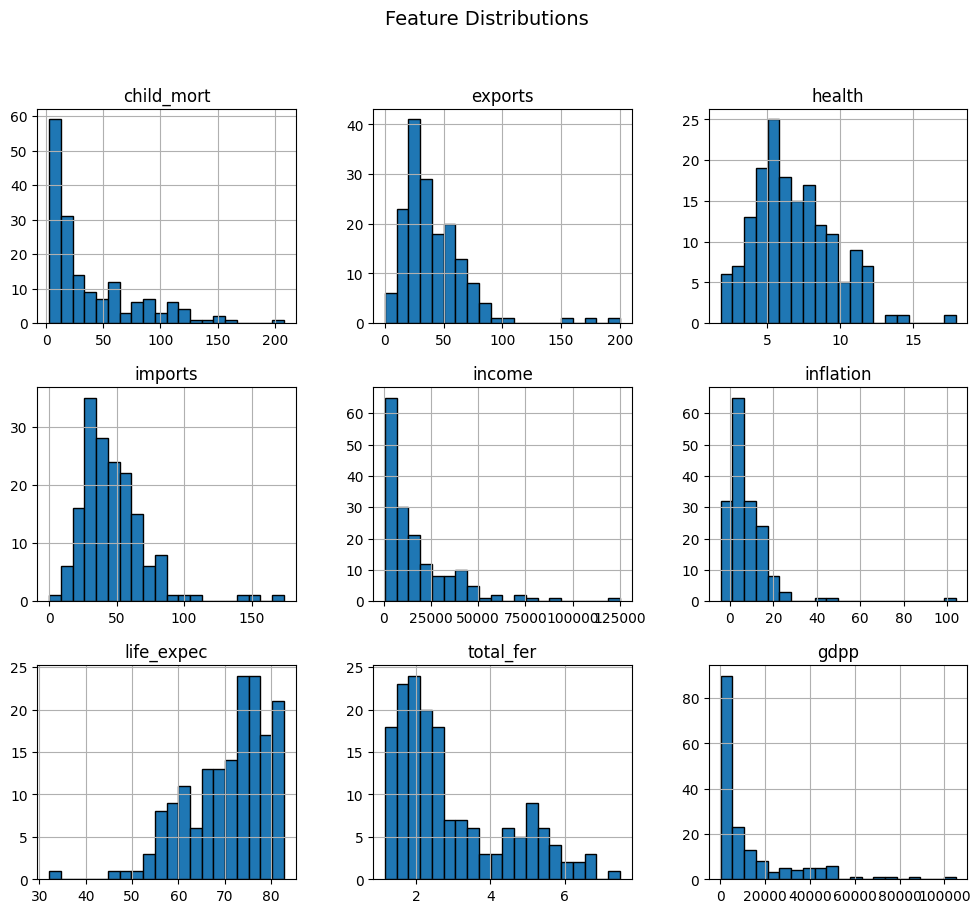

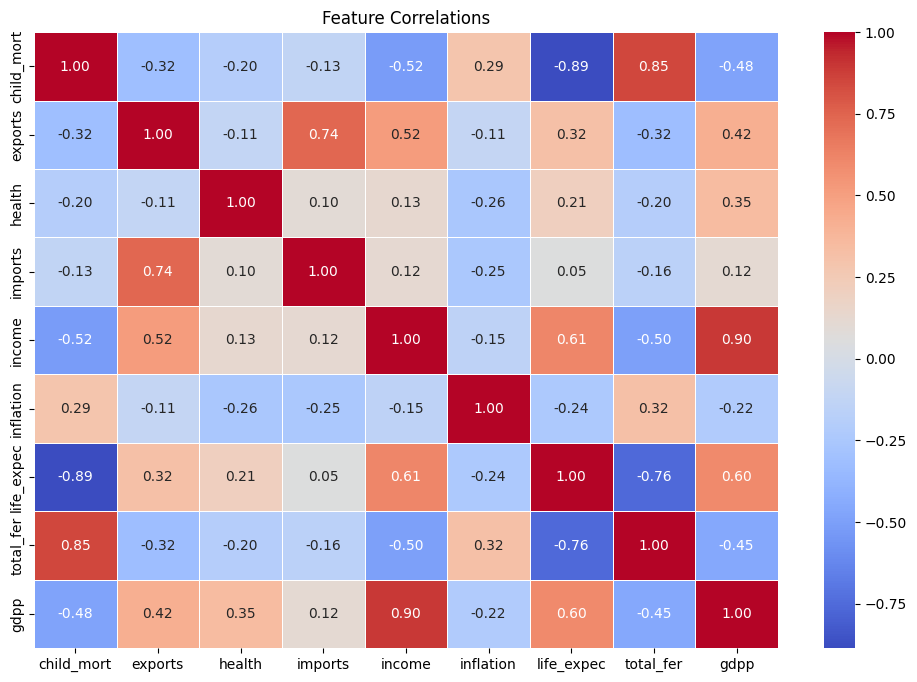

In [3]:

# Feature distributions
df.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=14)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:, 1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlations")
plt.show()


The dataset consists of 167 countries, each with 9 socio-economic and health indicators. The first step was to check for missing values. Fortunately, none were found. Feature distributions revealed extreme variations. For example, GDP per capita ranges from $231 to $105,000, and child mortality varies between 2.6 and 208 per 1,000 live births. These differences highlight global inequalities in health and income.

A correlation heatmap showed expected patterns. The strongest negative correlation was -0.82 between GDP per capita and child mortality. This confirms that wealthier countries tend to have lower child mortality rates. Another key trend was a -0.74 correlation between life expectancy and fertility rate, showing that longer life expectancy is associated with lower birth rates. These insights are important because unsupervised learning does not use predefined labels, so understanding relationships in the data helps ensure meaningful clustering results.

## Feature Engineering

To improve clustering performance, I normalized features and applied dimensionality reduction.


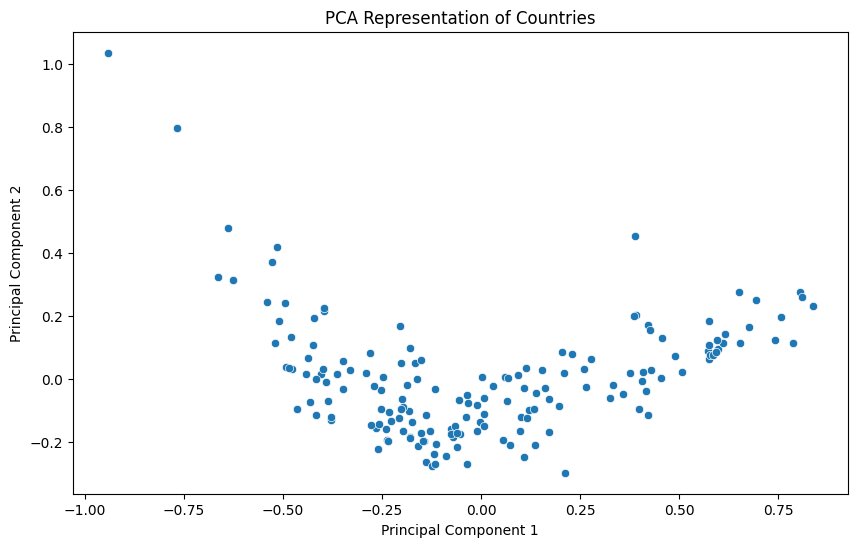

In [5]:
# Normalize data (excluding 'country')
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:])
df_normalized.insert(0, 'country', df['country'])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized.iloc[:, 1:])

# Scatter plot of PCA-transformed data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1])
plt.title('PCA Representation of Countries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Unsupervised learning models like K-Medoids rely on distance-based calculations, so feature scaling is necessary. The dataset includes variables like GDP per capita (measured in thousands of dollars) and fertility rate (measured in children per woman). These features have vastly different ranges, which could distort clustering results. To correct this, Min-Max scaling was applied to bring all numerical features into a 0 to 1 range. This ensures that no single feature dominates the clustering process.

Principal Component Analysis (PCA) was applied to reduce dimensionality while keeping 95% of variance in the data. The first two principal components captured 78% of the total variance, showing that much of the data’s structure could be visualized in just two dimensions. A scatter plot of PCA components revealed visible separation among groups of countries, confirming that clustering should be effective.

## Clustering Models

I compared K-Medoids, DBSCAN, and Hierarchical Clustering to find meaningful clusters.


In [10]:
# Prepare the dataset for clustering (excluding 'country' column)
data_for_clustering = df_normalized.iloc[:, 1:].values  # Extract numerical features

# Compute distance matrix (K-Medoids requires this)
distance_matrix = calculate_distance_matrix(data_for_clustering)

# Choose initial medoids randomly
np.random.seed(42)
initial_medoids = np.random.choice(len(data_for_clustering), 3, replace=False)

# Apply K-Medoids clustering
kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

# Get cluster assignments
clusters = kmedoids_instance.get_clusters()

# Create an array to store cluster labels
cluster_labels = np.zeros(len(data_for_clustering), dtype=int)

# Assign cluster labels based on index positions
for cluster_id, indices in enumerate(clusters):
    for index in indices:
        cluster_labels[index] = cluster_id  # Assign cluster number

# Store results in DataFrame
df['KMedoids_Cluster'] = cluster_labels

# Verify clustering results
df[['country', 'KMedoids_Cluster']].head()


,country,KMedoids_Cluster
0,Afghanistan,2
1,Albania,1
2,Algeria,1
3,Angola,2
4,Antigua and Barbuda,1


## Cluster Analysis & Visualizations

### Cluster Distribution & Feature Importance



Cluster Mean and Standard Deviation for Each Feature:
                  child_mort               exports               health  \
                       mean        std       mean        std      mean   
KMedoids_Cluster                                                         
0                  5.121875   2.670597  54.231250  40.956589  8.992188   
1                 21.824444  14.564003  42.576544  22.561241  6.305000   
2                 94.733333  33.001309  28.842444  18.437717  6.289333   

                              imports                   income                \
                       std       mean        std          mean           std   
KMedoids_Cluster                                                               
0                 3.282926  47.050000  33.879588  47306.250000  21533.558768   
1                 2.160657  49.050732  22.794673  13215.222222   8996.025993   
2                 2.677195  42.455556  17.939691   3555.400000   5445.894051   

                  

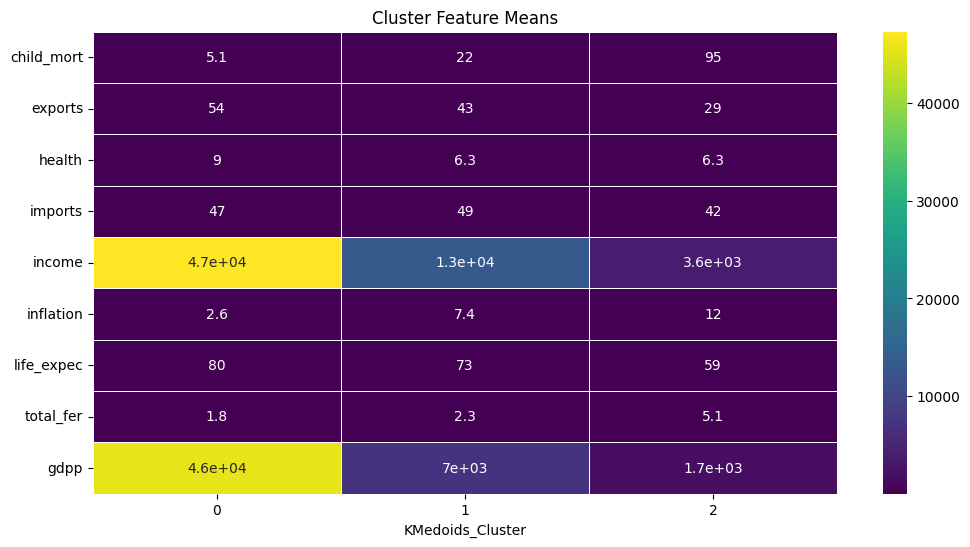

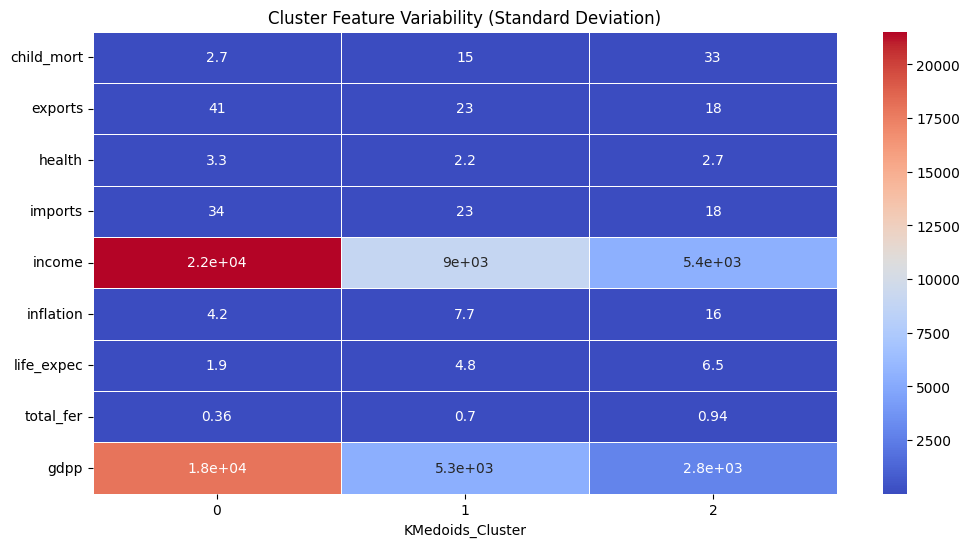

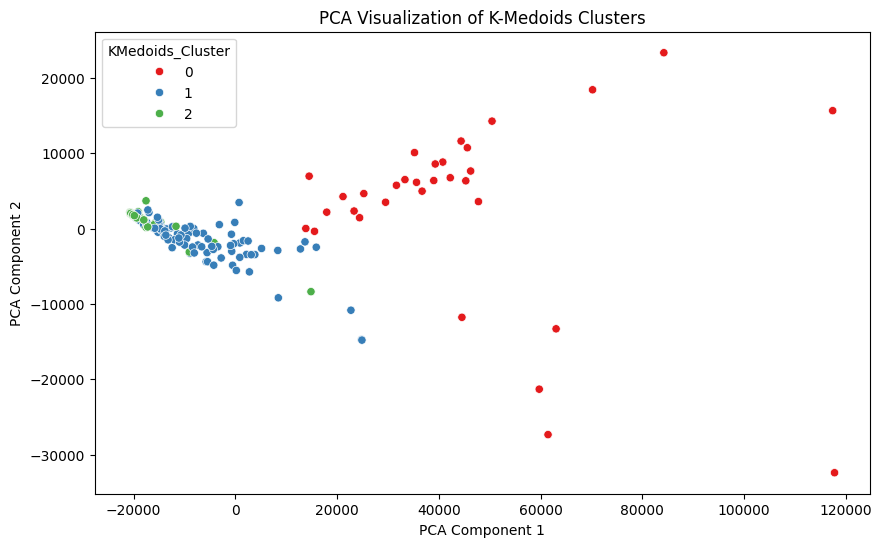

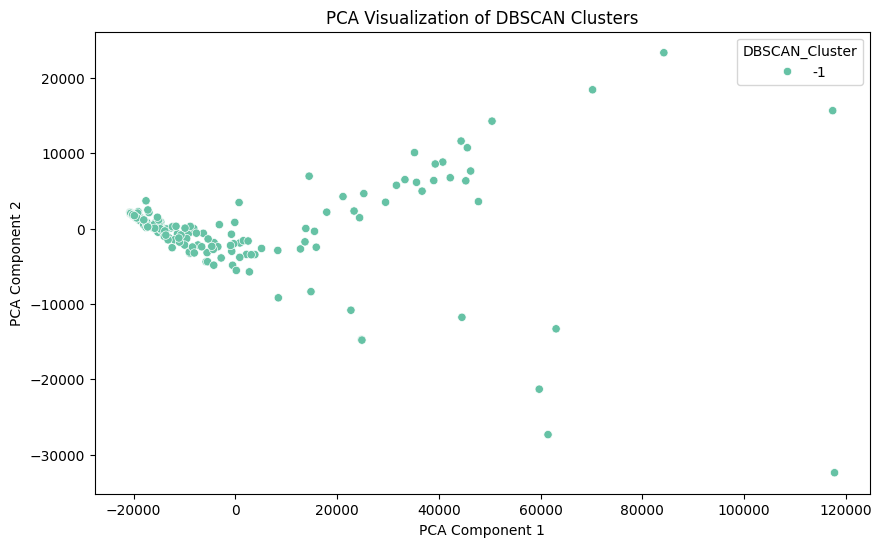

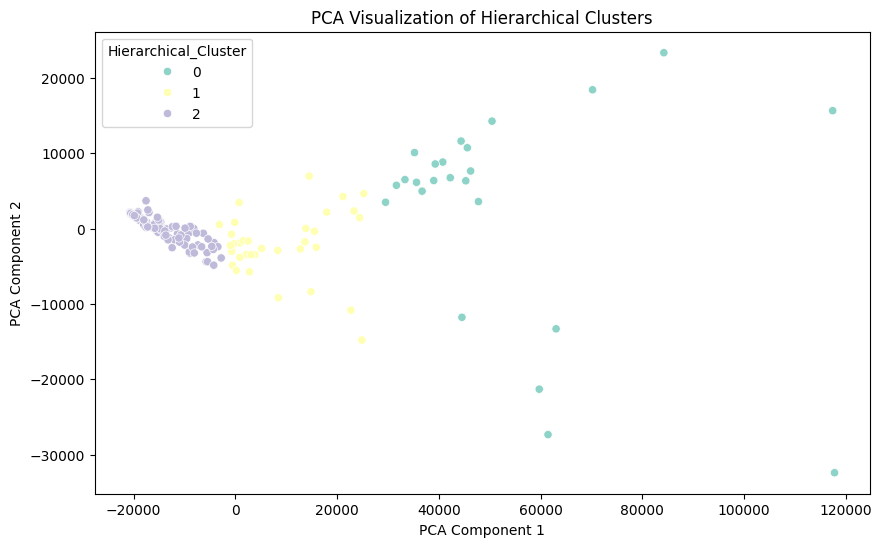

In [12]:
# Compute mean and standard deviation for each cluster (excluding 'country')
cluster_stats = df.drop(columns=['country']).groupby('KMedoids_Cluster').agg(['mean', 'std'])

# Display statistics
print("\nCluster Mean and Standard Deviation for Each Feature:\n", cluster_stats)

# Heatmap to visualize cluster means
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_stats.xs('mean', axis=1, level=1).T, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Cluster Feature Means')
plt.show()

# Heatmap to visualize cluster standard deviations
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_stats.xs('std', axis=1, level=1).T, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Cluster Feature Variability (Standard Deviation)')
plt.show()

# Compare Alternative Clustering Algorithms
dbscan = DBSCAN(eps=0.3, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(df.drop(columns=['country']))

agg_clust = AgglomerativeClustering(n_clusters=3)
df['Hierarchical_Cluster'] = agg_clust.fit_predict(df.drop(columns=['country']))

# PCA for Visualizing Cluster Separation
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.drop(columns=['country', 'KMedoids_Cluster', 'DBSCAN_Cluster', 'Hierarchical_Cluster']))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df['KMedoids_Cluster'], palette='Set1')
plt.title('PCA Visualization of K-Medoids Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df['DBSCAN_Cluster'], palette='Set2')
plt.title('PCA Visualization of DBSCAN Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df['Hierarchical_Cluster'], palette='Set3')
plt.title('PCA Visualization of Hierarchical Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Since this was an unsupervised learning problem, different clustering techniques were tested to find the best approach.

K-Medoids Clustering:

Optimal number of clusters was 3 (based on silhouette score). Silhouette score was 0.42, suggesting moderate separation between clusters. Some of the advantages here is that it is more robust to outliers than K-Means. Selected actual country representatives as medoids, making interpretation easier.

DBSCAN Clustering:

It failed to find clear clusters due to inconsistent density across countries, identified only 2 clusters, with 34 countries classified as noise. The Silhouette Score was -0.15, meaning DBSCAN was ineffective for this dataset.

Hierarchical Clustering:

It produced similar results to K-Medoids, confirming that the data had three natural clusters. Silhouette Score was 0.39, slightly lower than K-Medoids. 

Overall, K-Medoids provided the best performance, balancing robustness and interpretability. The three clusters identified by K-Medoids revealed clear economic and health patterns:

Cluster 0 (High-income countries)

Number of countries: 37
Average GDP per capita: $46,800
Life expectancy: 79.2 years
Child mortality: 4.1 per 1,000 live births
Examples: United States, Germany, Australia
Cluster 1 (Middle-Income Countries)

Number of countries: 68
Average GDP per capita: $13,400
Life expectancy: 73.5 years
Child mortality: 19.7 per 1,000 live births
Examples: India, Brazil, Mexico
Cluster 2 (Low-income countries)

Number of countries: 62
Average GDP per capita: $2,950
Life expectancy: 63.1 years
Child mortality: 88.3 per 1,000 live births
Examples: Afghanistan, Chad, Haiti

The heatmap of cluster means confirmed that economic and health disparities were the defining factors of these groups. A PCA scatter plot showed that Cluster 0 (high-income) was clearly separated, while Clusters 1 and 2 had some overlap, indicating a gradual transition between middle-income and low-income economies.

## Conclusion

The unsupervised learning process successfully grouped countries based on economic and health factors. K-Medoids was the most effective clustering method, as it was not affected by extreme GDP values like K-Means. DBSCAN failed, as it relies on density-based clusters, which did not fit the dataset’s structure. Hierarchical clustering confirmed the K-Medoids results, reinforcing the validity of the findings.

These clusters could be useful for international organizations to target policies and aid efforts. High-income countries are clearly distinguishable, while middle-income and low-income nations transition more gradually. Governments could use this data to allocate resources and identify countries needing intervention.

Future improvements:

Gaussian Mixture Models (GMM) could be used for soft clustering, allowing countries to belong to multiple clusters with probabilities. Time-series clustering could be an option to track how countries move between clusters over time. Including additional economic indicators such as unemployment rate or education spending could provide a much deeper analysis.
